In [ ]:
#unpacking zip
'''
import zipfile
from pathlib import Path

zip_dir = Path('data/jpegs/THLAR')

#unpacking the zip files
for zip_path in zip_dir.glob('*.zip'):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        extract_path = zip_path.with_suffix('')  # Remove '.zip' suffix for extraction folder
        extract_path.mkdir(exist_ok=True)       # Create directory if it doesn't exist
        zip_ref.extractall(extract_path)
        print(f'Extracted {zip_path.name} to {extract_path}')
'''

In [ ]:
#deleting the zip files
'''
for zip_path in zip_dir.glob('*.zip'):
    try:
        os.remove(zip_path)  # Delete the ZIP file
        print(f"Deleted: {zip_path}")
    except Exception as e:
        print(f"Error deleting {zip_path}: {e}")
'''

In [ ]:
#resize images
'''
from pathlib import Path
import cv2
import numpy as np

# === CONFIG ===
INPUT_ROOT = Path("data/jpegs/THLAR")
OUTPUT_ROOT = Path("resized_THLAR")
RESIZE_SHAPE = (224, 224)  # (width, height) for OpenCV

OUTPUT_ROOT.mkdir(parents=True, exist_ok=True)

for folder in INPUT_ROOT.iterdir():
    if folder.is_dir():
        output_folder = OUTPUT_ROOT / folder.name
        output_folder.mkdir(parents=True, exist_ok=True)

        image_files = list(folder.glob("*/*.jpg")) + list(folder.glob("*/*.jpeg"))
        print(f"\nProcessing folder: {folder.name} | Found {len(image_files)} images")

        for img_file in sorted(image_files):
            print(f"Reading: {img_file.name}")
            try:
                img = cv2.imread(str(img_file))
                if img is None or img.size == 0:
                    print(f"Failed to read image: {img_file}")
                    continue

                resized_img = cv2.resize(img, RESIZE_SHAPE)  # BGR, uint8
                save_path = output_folder / f"{img_file.stem}.jpg"
                success = cv2.imwrite(str(save_path), resized_img)

                if success:
                    print(f"Saved: {save_path}")
                else:
                    print(f"Failed to save: {save_path}")

            except Exception as e:
                print(f"ERROR processing {img_file.name}: {e}")
'''

In [ ]:
#image counts
'''
from pathlib import Path

resized_root = Path("resized_ARTVU")

folder_counts = {}

for folder in resized_root.iterdir():
    if folder.is_dir():
        count = len(list(folder.glob("*.jpg")))
        folder_counts[folder.name] = count

# Print the results
for folder_name, count in sorted(folder_counts.items()):
    print(f"{folder_name}: {count} images")

# Optional: Total count
total = sum(folder_counts.values())
print(f"\n Total images: {total}")
'''


=================================================
CODE MODEL TRAINING
=================================================

Starting training...


100%|██████████| 9/9 [01:19<00:00,  8.86s/it]


Epoch 1/8 | Loss: 2.8012


100%|██████████| 9/9 [01:24<00:00,  9.34s/it]


Epoch 2/8 | Loss: 2.4173


100%|██████████| 9/9 [01:25<00:00,  9.47s/it]


Epoch 3/8 | Loss: 1.7023


100%|██████████| 9/9 [01:27<00:00,  9.70s/it]


Epoch 4/8 | Loss: 0.7568


100%|██████████| 9/9 [01:34<00:00, 10.54s/it]


Epoch 5/8 | Loss: 0.1513


100%|██████████| 9/9 [01:36<00:00, 10.73s/it]


Epoch 6/8 | Loss: 0.1799


100%|██████████| 9/9 [01:34<00:00, 10.48s/it]


Epoch 7/8 | Loss: 0.1734


100%|██████████| 9/9 [01:37<00:00, 10.85s/it]

Epoch 8/8 | Loss: 0.1586
Model saved.


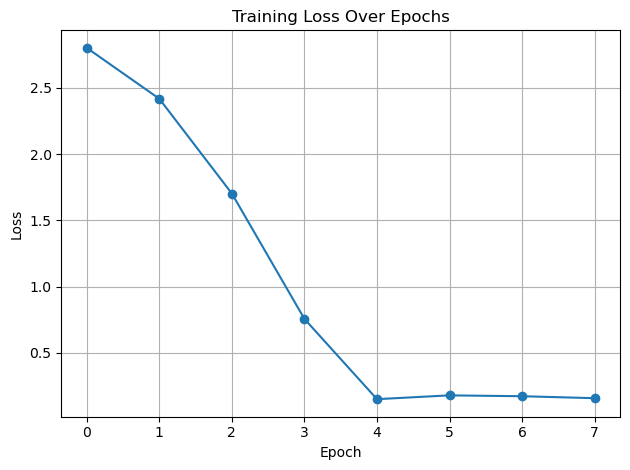

/var/folders/px/hcyk6qjs6hj0k5x4mb8p8vqm0000gn/T/ipykernel_74685/1060916051.py:216: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/px/hcyk6qjs6hj0k5x4mb8p8vqm0000gn/T/ipykernel_74685/1060916051.py:217: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig("prediction_vs_actual.png")
/Users/mabhatti/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


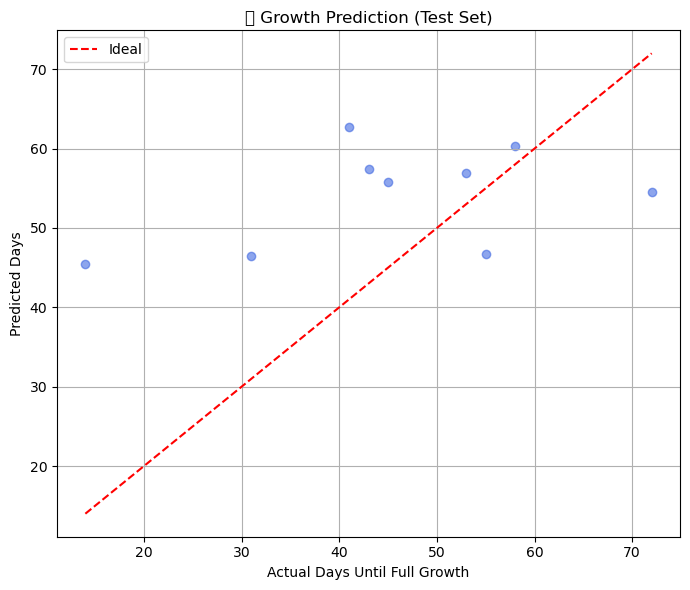

In [8]:
# Full implementation (enhanced) with EfficientNet, quantile loss, LR scheduler, and extended training

import re
import ast
import torch
import random
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime, timedelta
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence

# === CONFIG ===
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

IMAGE_ROOT = Path("resized_THLAR")
IMAGE_SIZE = 224
TRAIN_CSV = "train_metadata.csv"
TEST_CSV = "test_metadata.csv"
MODEL_PATH = "trained_model.pth"
BATCH_SIZE = 4
NUM_EPOCHS = 8
LR = 1e-4
MAX_SEQ_LEN = 15

# === Step 1: Build metadata from image folders ===
def parse_filename(filename):
    match = re.match(r'THLAR_(\d+)_(\d{4})Y(\d{2})M(\d{2})D_(\d{2})H(\d{2})M(\d{2})S', filename)
    if match:
        plant_id, y, m, d, H, M, S = match.groups()
        timestamp = datetime(int(y), int(m), int(d), int(H), int(M), int(S))
        return plant_id, timestamp
    return None, None

records = []
for folder in IMAGE_ROOT.iterdir():
    if folder.is_dir():
        imgs = sorted(folder.glob("*.jpg"))
        parsed = []
        for img in imgs:
            pid, ts = parse_filename(img.stem)
            if pid and ts:
                parsed.append((img, ts))
        if len(parsed) < 4:
            continue
        parsed.sort(key=lambda x: x[1])
        first_ts, last_ts = parsed[0][1], parsed[-1][1]
        total_days = (last_ts - first_ts).days + 1

        cutoff_date = first_ts + timedelta(days=15)
        early_imgs = [str(p[0]) for p in parsed if p[1] <= cutoff_date][:MAX_SEQ_LEN]

        if len(early_imgs) < 4:
            continue

        records.append({
            "plant_id": folder.name,
            "input_images": early_imgs,
            "total_growth_days": total_days
        })

# Save train/test splits
df = pd.DataFrame(records)
df["log_growth_days"] = np.log(df["total_growth_days"])
train_df, test_df = train_test_split(df, test_size=0.2, random_state=SEED)
train_df.to_csv(TRAIN_CSV, index=False)
test_df.to_csv(TEST_CSV, index=False)

# === Step 2: Dataset ===
class PlantGrowthDataset(Dataset):
    def __init__(self, csv_path, image_size=224):
        self.df = pd.read_csv(csv_path)
        self.df['input_images'] = self.df['input_images'].apply(ast.literal_eval)
        self.transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        images = []
        time_indices = []
        for i, img_path in enumerate(row["input_images"]):
            img = Image.open(img_path).convert("RGB")
            img = self.transform(img)
            images.append(img)
            time_indices.append(i / MAX_SEQ_LEN)
        sequence = torch.stack(images)  # [T, C, H, W]
        time_tensor = torch.tensor(time_indices).unsqueeze(1)  # [T, 1]
        label = torch.tensor(row["log_growth_days"], dtype=torch.float32)
        return sequence, time_tensor, label

# === Step 3: Collate function ===
def collate_fn(batch):
    sequences, time_idxs, targets = zip(*batch)
    lengths = [s.shape[0] for s in sequences]
    padded_seq = pad_sequence(sequences, batch_first=True)  # [B, T, C, H, W]
    padded_time = pad_sequence(time_idxs, batch_first=True)  # [B, T, 1]
    return padded_seq, padded_time, torch.tensor(lengths), torch.tensor(targets, dtype=torch.float32)

# === Step 4: Model with EfficientNet ===
class GrowthRegressor(nn.Module):
    def __init__(self, rnn_hidden=256):
        super().__init__()
        base_cnn = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
        self.feature_dim = base_cnn.classifier[1].in_features
        base_cnn.classifier = nn.Identity()
        self.cnn = base_cnn

        self.rnn = nn.LSTM(input_size=self.feature_dim + 1, hidden_size=rnn_hidden, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(rnn_hidden, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 1)
        )

    def forward(self, x, time_emb, lengths):
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)
        feats = self.cnn(x)  # [B*T, F]
        feats = feats.view(B, T, -1)
        feats = torch.cat([feats, time_emb.to(feats.device)], dim=2)

        packed = pack_padded_sequence(feats, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (hn, _) = self.rnn(packed)
        out = self.fc(hn.squeeze(0))
        return out.squeeze(1)

# === Step 5: Quantile loss ===
def quantile_loss(pred, target, q=0.8):
    error = target - pred
    return torch.mean(torch.max(q * error, (q - 1) * error))

# === Step 6: Training ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GrowthRegressor().to(device)

train_ds = PlantGrowthDataset(TRAIN_CSV)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

print("Starting training...")
train_losses = []
for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0
    for x, t, lengths, y in tqdm(train_dl):
        x, t, y = x.to(device), t.to(device), y.to(device)
        preds = model(x, t, lengths)
        loss = quantile_loss(preds, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_dl)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Loss: {avg_loss:.4f}")
    scheduler.step(avg_loss)

torch.save(model.state_dict(), MODEL_PATH)
print("Model saved.")

# Plot training loss
plt.figure()
plt.plot(train_losses, marker='o')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.savefig("training_loss.png")
plt.show()

# === Step 7: Evaluation ===
model.eval()
test_ds = PlantGrowthDataset(TEST_CSV)
test_dl = DataLoader(test_ds, batch_size=1, shuffle=False, collate_fn=collate_fn)

preds, targets = [], []
with torch.no_grad():
    for x, t, lengths, y in test_dl:
        x, t = x.to(device), t.to(device)
        pred = model(x, t, lengths).cpu().item()
        preds.append(np.exp(pred))
        targets.append(np.exp(y.item()))

plt.figure(figsize=(7, 6))
plt.scatter(targets, preds, color="royalblue", alpha=0.6)
plt.plot([min(targets), max(targets)], [min(targets), max(targets)], 'r--', label="Ideal")
plt.xlabel("Actual Days Until Full Growth")
plt.ylabel("Predicted Days")
plt.title("\U0001F4C8 Growth Prediction (Test Set)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("prediction_vs_actual.png")
plt.show()



/var/folders/px/hcyk6qjs6hj0k5x4mb8p8vqm0000gn/T/ipykernel_74685/3710254927.py:31: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/px/hcyk6qjs6hj0k5x4mb8p8vqm0000gn/T/ipykernel_74685/3710254927.py:32: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig("prediction_vs_actual_bias_corrected.png")
/Users/mabhatti/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


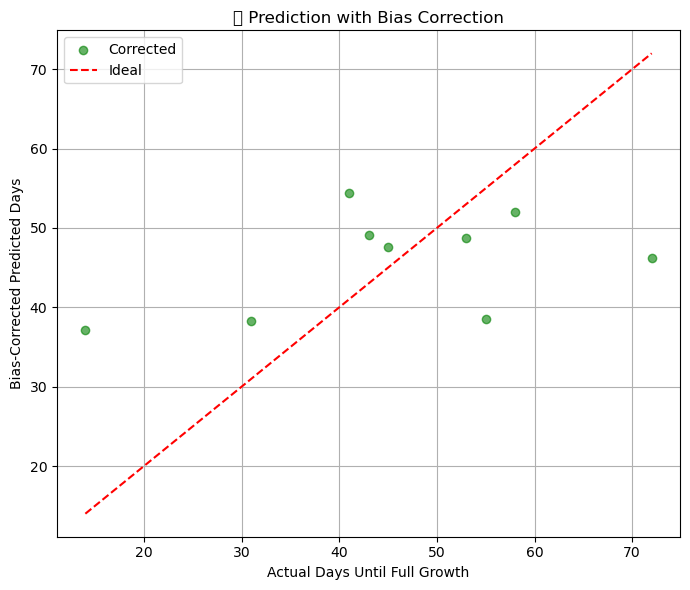

In [11]:
# === Step 7: Evaluation with Bias Correction ===
model.eval()
test_ds = PlantGrowthDataset(TEST_CSV)
test_dl = DataLoader(test_ds, batch_size=1, shuffle=False, collate_fn=collate_fn)

preds, targets = [], []
with torch.no_grad():
    for x, t, lengths, y in test_dl:
        x, t = x.to(device), t.to(device)
        pred = model(x, t, lengths).cpu().item()
        preds.append(np.exp(pred))
        targets.append(np.exp(y.item()))

preds = np.array(preds)
targets = np.array(targets)

# === Apply bias correction ===
bias = np.mean(preds - targets)
bias_corrected_preds = preds - bias

# === Plot with Bias Correction ===
plt.figure(figsize=(7, 6))
plt.scatter(targets, bias_corrected_preds, color="green", alpha=0.6, label="Corrected")
plt.plot([min(targets), max(targets)], [min(targets), max(targets)], 'r--', label="Ideal")
plt.xlabel("Actual Days Until Full Growth")
plt.ylabel("Bias-Corrected Predicted Days")
plt.title("📈 Prediction with Bias Correction")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("prediction_vs_actual_bias_corrected.png")
plt.show()